In [7]:
import pandas as pd
import numpy as np

# Charger les données
df = pd.read_csv("train_data.csv")

# Afficher les informations sur le dataset pour mieux comprendre sa structure
print("Informations sur le dataset :")
print(df.info())

# Vérification des valeurs NaN
print("\nVérification des valeurs NaN dans le dataset :")
print(df.isnull().sum())

# Remplacer les valeurs NaN par la médiane des colonnes numériques
# Nous utilisons la médiane pour éviter de fausser les données avec des valeurs extrêmes
df.fillna(df.median(), inplace=True)

# Vérification des valeurs infinies (inf, -inf)
print("\nVérification des valeurs infinies dans le dataset :")
print(np.isinf(df).sum())

# Remplacer les valeurs infinies par une valeur NaN puis les imputons avec la médiane
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(df.median(), inplace=True)

# Vérification des valeurs extrêmes (trop grandes) dans les colonnes numériques
print("\nVérification des valeurs trop grandes dans le dataset :")
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Afficher les colonnes avec des valeurs extrêmes
for col in numeric_cols:
    max_val = df[col].max()
    min_val = df[col].min()
    if max_val > 1e5 or min_val < -1e5:  # seuil arbitraire pour détecter des valeurs trop grandes
        print(f"Colonne {col} : max = {max_val}, min = {min_val}")

# Si nécessaire, normaliser ou limiter les valeurs trop grandes
# Limitation des valeurs à un certain seuil pour éviter des valeurs extrêmes trop grandes
df[numeric_cols] = df[numeric_cols].apply(lambda x: np.clip(x, -1e5, 1e5))

# Vérification après modification
print("\nVérification des valeurs après modification :")
print(np.isinf(df).sum())
print(df.isnull().sum())

# Sauvegarder le dataset nettoyé
df.to_csv("train_data_cleaned.csv", index=False)

print("\nDonnées nettoyées et sauvegardées sous 'train_data_cleaned.csv'")


Informations sur le dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42571 entries, 0 to 42570
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   player1_avg_aces     32137 non-null  float64
 1   player2_avg_aces     31933 non-null  float64
 2   player1_avg_1stIn    32137 non-null  float64
 3   player2_avg_1stIn    31933 non-null  float64
 4   player1_avg_1stWon   32137 non-null  float64
 5   player2_avg_1stWon   31933 non-null  float64
 6   player1_avg_2ndWon   32137 non-null  float64
 7   player2_avg_2ndWon   31933 non-null  float64
 8   player1_ht           41733 non-null  float64
 9   player2_ht           41818 non-null  float64
 10  player1_age          42566 non-null  float64
 11  player2_age          42570 non-null  float64
 12  player1_rank         42090 non-null  float64
 13  player2_rank         42119 non-null  float64
 14  player1_rank_points  42090 non-null  float64
 15  player

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Charger les données
df = pd.read_csv("train_data_cleaned.csv")

# Sélectionner les colonnes de caractéristiques
features = ['player1_avg_aces', 'player2_avg_aces', 'player1_avg_1stIn', 'player2_avg_1stIn',
            'player1_avg_1stWon', 'player2_avg_1stWon', 'player1_avg_2ndWon', 'player2_avg_2ndWon',
            'player1_ht', 'player2_ht', 'player1_age', 'player2_age', 'player1_rank', 'player2_rank',
            'player1_rank_points', 'player2_rank_points', 'player1_ace', 'player2_ace']

# Caractéristiques (features) et cibles (targets)
X = df[features]  # Caractéristiques
y_player1 = df['player1_ace']  # Cible pour player1
y_player2 = df['player2_ace']  # Cible pour player2

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train_player1, y_test_player1 = train_test_split(X, y_player1, test_size=0.2, random_state=42)
X_train, X_test, y_train_player2, y_test_player2 = train_test_split(X, y_player2, test_size=0.2, random_state=42)

# Normalisation des caractéristiques
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modèle Random Forest pour player1 (prédire les aces de player1)
rf_model_player1 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_player1.fit(X_train_scaled, y_train_player1)

# Modèle Random Forest pour player2 (prédire les aces de player2)
rf_model_player2 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_player2.fit(X_train_scaled, y_train_player2)

# Prédictions sur l'ensemble de test
y_pred_player1 = rf_model_player1.predict(X_test_scaled)
y_pred_player2 = rf_model_player2.predict(X_test_scaled)

# Évaluation des modèles
mae_player1 = mean_absolute_error(y_test_player1, y_pred_player1)
mae_player2 = mean_absolute_error(y_test_player2, y_pred_player2)

print(f"Mean Absolute Error pour player1 (aces) : {mae_player1:.4f}")
print(f"Mean Absolute Error pour player2 (aces) : {mae_player2:.4f}")


Mean Absolute Error pour player1 (aces) : 0.0004
Mean Absolute Error pour player2 (aces) : 0.0003


Performance pour player1 :
RMSE: 0.8115675039990118
MAE: 0.5882655367861265
R²: 0.2999075739397862


Performance pour player2 :
RMSE: 0.8333196600723222
MAE: 0.6046699781417034
R²: 0.28092435306739216


Validation croisée (player1) :
Score moyen : -0.6888265376957536
Écart type : 0.039177095625810864

Validation croisée (player2) :
Score moyen : -0.7019409961902252
Écart type : 0.04350358781550167




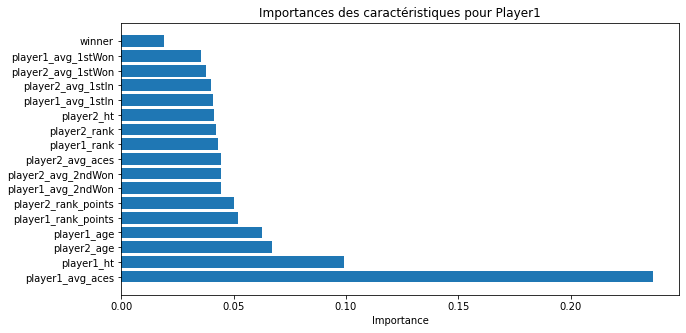

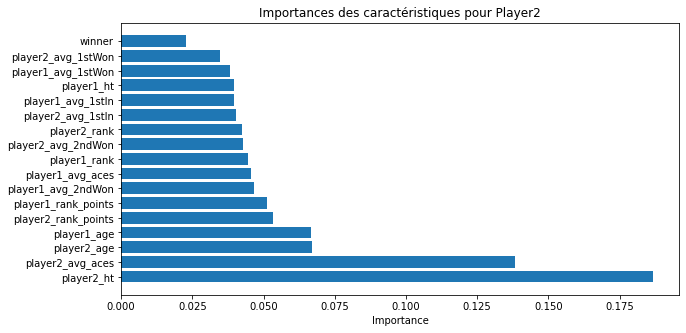

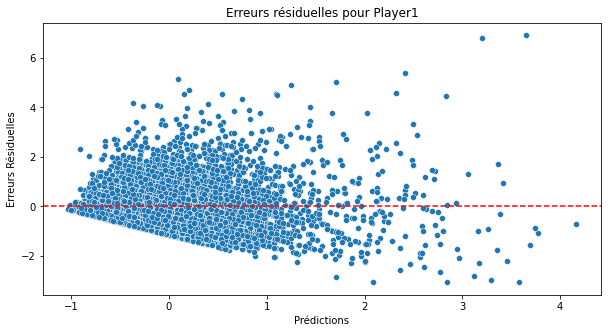

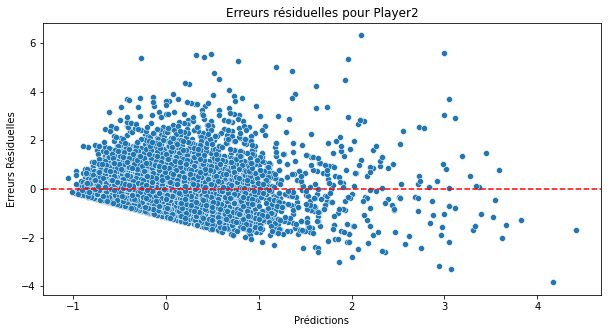

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les données nettoyées
data = pd.read_csv("train_data_cleaned.csv")

# Sélectionner les variables d'entrée et la cible
X = data.drop(columns=['player1_ace', 'player2_ace'])  # Variables explicatives
y1 = data['player1_ace']  # Cible pour player1
y2 = data['player2_ace']  # Cible pour player2

# Diviser les données en jeux d'entraînement et de test (80% train, 20% test)
X_train, X_test, y_train1, y_test1 = train_test_split(X, y1, test_size=0.2, random_state=42)
X_train, X_test, y_train2, y_test2 = train_test_split(X, y2, test_size=0.2, random_state=42)

# Initialiser le modèle RandomForest
rf1 = RandomForestRegressor(n_estimators=100, random_state=42)
rf2 = RandomForestRegressor(n_estimators=100, random_state=42)

# Entraîner les modèles
rf1.fit(X_train, y_train1)
rf2.fit(X_train, y_train2)

# Prédictions sur le jeu de test
y_pred1 = rf1.predict(X_test)
y_pred2 = rf2.predict(X_test)

# Calcul des métriques pour player1
mse1 = mean_squared_error(y_test1, y_pred1)
mae1 = mean_absolute_error(y_test1, y_pred1)
rmse1 = np.sqrt(mse1)
r2_1 = r2_score(y_test1, y_pred1)

# Calcul des métriques pour player2
mse2 = mean_squared_error(y_test2, y_pred2)
mae2 = mean_absolute_error(y_test2, y_pred2)
rmse2 = np.sqrt(mse2)
r2_2 = r2_score(y_test2, y_pred2)

# Affichage des résultats pour player1
print("Performance pour player1 :")
print(f"RMSE: {rmse1}")
print(f"MAE: {mae1}")
print(f"R²: {r2_1}")
print("\n")

# Affichage des résultats pour player2
print("Performance pour player2 :")
print(f"RMSE: {rmse2}")
print(f"MAE: {mae2}")
print(f"R²: {r2_2}")
print("\n")

# Validation croisée pour évaluer la robustesse du modèle
cv_scores1 = cross_val_score(rf1, X, y1, cv=5, scoring='neg_mean_squared_error')
cv_scores2 = cross_val_score(rf2, X, y2, cv=5, scoring='neg_mean_squared_error')

print("Validation croisée (player1) :")
print(f"Score moyen : {cv_scores1.mean()}")
print(f"Écart type : {cv_scores1.std()}")

print("\nValidation croisée (player2) :")
print(f"Score moyen : {cv_scores2.mean()}")
print(f"Écart type : {cv_scores2.std()}")
print("\n")

# Affichage des importances des caractéristiques
importances1 = rf1.feature_importances_
importances2 = rf2.feature_importances_

# Tracer l'importance des caractéristiques pour player1
feature_names = X.columns
indices1 = np.argsort(importances1)[::-1]  # Classement des caractéristiques par importance
indices2 = np.argsort(importances2)[::-1]  # Classement des caractéristiques par importance

plt.figure(figsize=(10, 5))
plt.title("Importances des caractéristiques pour Player1")
plt.barh(range(X.shape[1]), importances1[indices1], align="center")
plt.yticks(range(X.shape[1]), [feature_names[i] for i in indices1])
plt.xlabel("Importance")
plt.show()

# Tracer l'importance des caractéristiques pour player2
plt.figure(figsize=(10, 5))
plt.title("Importances des caractéristiques pour Player2")
plt.barh(range(X.shape[1]), importances2[indices2], align="center")
plt.yticks(range(X.shape[1]), [feature_names[i] for i in indices2])
plt.xlabel("Importance")
plt.show()

# Analyse des erreurs (résidus)
residuals1 = y_test1 - y_pred1
residuals2 = y_test2 - y_pred2

plt.figure(figsize=(10, 5))
plt.title("Erreurs résiduelles pour Player1")
sns.scatterplot(x=y_pred1, y=residuals1)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Prédictions")
plt.ylabel("Erreurs Résiduelles")
plt.show()

plt.figure(figsize=(10, 5))
plt.title("Erreurs résiduelles pour Player2")
sns.scatterplot(x=y_pred2, y=residuals2)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Prédictions")
plt.ylabel("Erreurs Résiduelles")
plt.show()

